In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-aspects/all_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_sentences.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled_sentences.csv
/kaggle/input/all-aspects/cleaned.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects.csv
/kaggle/input/all-aspects/all_aspects.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_cleaned_sentences.csv


In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import sys
import time
import tqdm

import numpy as np
import pandas as pd

import pickle

import string
import io
import re
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from IPython.display import Markdown, clear_output

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
df = pd.read_csv("../input/all-aspects/cleaned.csv")
df.head()

,rid,sid,app,review,cleaned,aspect,sentiment,aspect_polarity
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Uygulama da kartlar da Troy kart geçmiyor uygu...,Troy,Negative,0
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Uygulama da kartlar da Troy kart geçmiyor uygu...,Troy,Neutral,1
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,güncelleme de kötüleşen Turkcell in ara ara ha...,Turkcell,Negative,0
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,BiP’ten aranmıyor yardım,BiP’ten,Negative,0
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP,Positive,2


In [6]:
df.isnull().sum()

rid                  0
sid                  0
app                  0
review               0
cleaned            224
aspect               0
sentiment            0
aspect_polarity      0
dtype: int64

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}

In [9]:
df['text'] = df['aspect'] + " [SEP] " + df['review']

In [10]:
df = df[["text", "aspect_polarity"]]

In [28]:
torch.cuda.empty_cache()
tokenizer = ElectraTokenizerFast.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator")
model = ElectraForSequenceClassification.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator", num_labels=3).to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [30]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(train_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [31]:
train_size = 0.9
df_train, df_validation, df_test = train_validate_test_split(df, train_size)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Full dataset: {df.shape[0]}")
print(f"Train dataset: {df_train.shape[0]}")
print(f"Valid dataset: {df_validation.shape[0]}")
print(f"Test dataset: {df_test.shape[0]}")

Full dataset: 157279
Train dataset: 141551
Valid dataset: 7863
Test dataset: 7865


In [32]:
MAX_LEN = 64
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5

In [33]:
training_set = SentimentDataset(df_train["text"].to_numpy(), df_train["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)
validation_set = SentimentDataset(df_validation["text"].to_numpy(), df_validation["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)
testing_set = SentimentDataset(df_test["text"].to_numpy(), df_test["aspect_polarity"].to_numpy(), tokenizer, MAX_LEN)

In [34]:
train_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}
valid_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

In [35]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(training_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [36]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm.tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [37]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm.tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [38]:
%%time

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, training_loader, optimizer, scheduler, device)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, validation_loader, device)
    print(f'Val   loss {val_loss} accuracy {val_acc}')

Epoch 1/2
----------


100%|██████████| 2212/2212 [23:48<00:00,  1.55it/s]


Train loss 0.4849447808068441 accuracy 0.8197045587809341


100%|██████████| 123/123 [00:28<00:00,  4.39it/s]


Val   loss 0.4090587730572476 accuracy 0.8512018313620756
Epoch 2/2
----------


100%|██████████| 2212/2212 [23:51<00:00,  1.55it/s]


Train loss 0.37893144468394585 accuracy 0.8643739712188541


100%|██████████| 123/123 [00:28<00:00,  4.38it/s]

Val   loss 0.38413710552987046 accuracy 0.8623934884903981
CPU times: user 48min 35s, sys: 3.23 s, total: 48min 38s
Wall time: 48min 36s


In [39]:
y_pred = []
y_true = []

model = model.eval()

with torch.no_grad():
    for d in testing_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [40]:
model_precision_score = precision_score(y_true, y_pred, average='macro')
model_f1_score = f1_score(y_true, y_pred, average='macro')
model_recall_score = recall_score(y_true, y_pred, average='macro')
model_accuracy_score = accuracy_score(y_true, y_pred)

print(f"Precision Score = {model_precision_score * 100:.2f}%")
print(f"F1 Score = {model_f1_score * 100:.2f}%")
print(f"Recall Score = {model_recall_score * 100:.2f}%")
print(f"Accuracy Score = {model_accuracy_score * 100:.2f}%")

Precision Score = 71.70%
F1 Score = 65.43%
Recall Score = 63.79%
Accuracy Score = 85.58%


In [41]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.85      0.94      0.89      4286
     Neutral       0.41      0.14      0.21       391
    Positive       0.89      0.83      0.86      3188

    accuracy                           0.86      7865
   macro avg       0.72      0.64      0.65      7865
weighted avg       0.84      0.86      0.84      7865



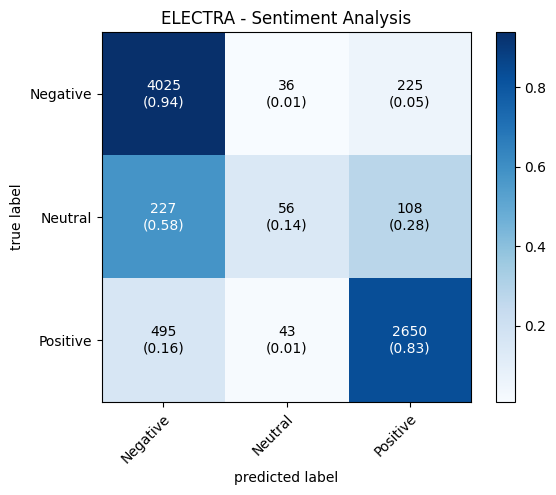

In [42]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"])
plt.title("ELECTRA - Sentiment Analysis")
plt.show()